In [1]:
## Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy import stats
import bisect
import warnings
warnings.filterwarnings('ignore')

from xgboost.sklearn import XGBRegressor
from sklearn import model_selection, preprocessing
import xgboost as xgb

%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('test.csv', parse_dates=['timestamp'])
macro_df = pd.read_csv('macro.csv', parse_dates=['timestamp'])
id_test = test_df.id
train_df.sample(3)
#train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
25457,25460,2014-11-28,38,20.0,8.0,14.0,1.0,1984.0,1.0,8.0,...,26,5,1,13,19,0,2,78,11,6800000
17092,17095,2014-04-07,42,NaN,2.0,3.0,2.0,NaN,1.0,1.0,...,0,0,0,0,3,0,0,0,0,3160790
11241,11244,2013-10-15,41,10.0,15.0,17.0,2.0,2004.0,2.0,19.0,...,3,1,0,0,6,0,0,3,2,4900000


In [3]:
macro_df.sample(3)

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
1826,2015-01-01,46.3414,21514.7,0.4,452.0,513.9,123.661,15.183,75.8,57.9981,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
1537,2014-03-18,106.8776,19566.5,2.1,411.2,485.6,113.465,13.698,16.8,36.2463,...,NaN,10311.0,NaN,0.44784,NaN,398451.0,28.20,NaN,46080.0,229294.8
959,2012-08-17,113.0900,16149.0,4.2,373.8,441.9,100.000,12.794,4.6,32.0443,...,NaN,8522.0,603.0,0.45070,1309.0,288177.0,23.01,67.85,42551.0,232840.2


In [4]:
print(train_df.columns.values)

['id' 'timestamp' 'full_sq' 'life_sq' 'floor' 'max_floor' 'material'
 'build_year' 'num_room' 'kitch_sq' 'state' 'product_type' 'sub_area'
 'area_m' 'raion_popul' 'green_zone_part' 'indust_part'
 'children_preschool' 'preschool_quota' 'preschool_education_centers_raion'
 'children_school' 'school_quota' 'school_education_centers_raion'
 'school_education_centers_top_20_raion' 'hospital_beds_raion'
 'healthcare_centers_raion' 'university_top_20_raion' 'sport_objects_raion'
 'additional_education_raion' 'culture_objects_top_25'
 'culture_objects_top_25_raion' 'shopping_centers_raion' 'office_raion'
 'thermal_power_plant_raion' 'incineration_raion' 'oil_chemistry_raion'
 'radiation_raion' 'railroad_terminal_raion' 'big_market_raion'
 'nuclear_reactor_raion' 'detention_facility_raion' 'full_all' 'male_f'
 'female_f' 'young_all' 'young_male' 'young_female' 'work_all' 'work_male'
 'work_female' 'ekder_all' 'ekder_male' 'ekder_female' '0_6_all' '0_6_male'
 '0_6_female' '7_14_all' '7_14_male' 

In [5]:
train_cp = train_df.copy()
train_cp['Source']='Train'
test_cp = test_df.copy()
test_cp['Source']='Test'
alldata = pd.concat([train_cp, test_cp],ignore_index=True)

macro_df.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in macro_df.columns ]
alldata=alldata.merge(macro_df,on='timestamp',how='left')

In [6]:
alldata['mnth_yr'] = alldata['timestamp'].apply(lambda x: x.strftime('%B-%Y'))

In [7]:
alldata['mnth_yr'] .head()

0       August-2011
1       August-2011
2       August-2011
3    September-2011
4    September-2011
Name: mnth_yr, dtype: object

In [8]:
macro_df.shape

(2484, 100)

In [9]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38133 entries, 0 to 38132
Columns: 393 entries, 0_13_all to mnth_yr
dtypes: datetime64[ns](1), float64(215), int64(157), object(20)
memory usage: 114.6+ MB


In [10]:
excl_col=['id','timestamp','sub_area'] + [c for c in alldata.columns if alldata[c].dtype=='object']
excl_col

['id',
 'timestamp',
 'sub_area',
 'Source',
 'big_market_raion',
 'big_road1_1line',
 'culture_objects_top_25',
 'detention_facility_raion',
 'ecology',
 'incineration_raion',
 'nuclear_reactor_raion',
 'oil_chemistry_raion',
 'product_type',
 'radiation_raion',
 'railroad_1line',
 'railroad_terminal_raion',
 'sub_area',
 'thermal_power_plant_raion',
 'water_1line',
 'mac__child_on_acc_pre_school',
 'mac__modern_education_share',
 'mac__old_education_build_share',
 'mnth_yr']

In [11]:
for f in alldata.columns:
    if f not in ['timestamp','Source','sub_area']:
        if alldata[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(alldata[f].values)) 
            alldata[f] = lbl.transform(list(alldata[f].values))

In [12]:
alldata.sub_area.head()

0             Bibirevo
1    Nagatinskij Zaton
2       Tekstil'shhiki
3               Mitino
4            Basmannoe
Name: sub_area, dtype: object

In [13]:
#sub_area & Source
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38133 entries, 0 to 38132
Columns: 393 entries, 0_13_all to mnth_yr
dtypes: datetime64[ns](1), float64(215), int64(175), object(2)
memory usage: 114.6+ MB


In [14]:
excl_col=['id','timestamp','sub_area',
          'mac__child_on_acc_pre_school','mac__modern_education_share','mac__old_education_build_share'] + [
          c for c in alldata.columns if alldata[c].dtype=='object']
resv_col=['price_doc','Source','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg',
          'cafe_avg_price_500','hospital_beds_raion']
excl_col

['id',
 'timestamp',
 'sub_area',
 'mac__child_on_acc_pre_school',
 'mac__modern_education_share',
 'mac__old_education_build_share',
 'Source',
 'sub_area']

In [15]:
def sel_grp(keys):
    lst_all = list()
    for k in keys:
        lst = [c for c in alldata.columns if c.find(k)!=-1 and c not in excl_col and c not in resv_col]
        lst = list(set(lst))
        lst_all += lst
    return(lst_all)

In [16]:
col_grp = dict({})
col_grp['people']=sel_grp(['_all','male'])
col_grp['id'] = sel_grp(['ID_'])
col_grp['church']=sel_grp(['church'])
col_grp['build']=sel_grp(['build_count_'])
col_grp['cafe']=sel_grp(['cafe_count'])
col_grp['cafeprice']=sel_grp(['cafe_sum','cafe_avg'])
col_grp['km']=sel_grp(['_km','metro_min','_avto_min','_walk_min','_min_walk'])
col_grp['mosque']=sel_grp(['mosque_count'])
col_grp['market']=sel_grp(['market_count'])
col_grp['office']=sel_grp(['office_count'])
col_grp['leisure']=sel_grp(['leisure_count'])
col_grp['sport']=sel_grp(['sport_count'])
col_grp['green']=sel_grp(['green_part'])
col_grp['prom']=sel_grp(['prom_part'])
col_grp['trc']=sel_grp(['trc_count'])
col_grp['sqm']=sel_grp(['_sqm_'])
col_grp['raion']=sel_grp(['_raion'])
col_grp['macro']=sel_grp(['mac__'])
col_grp.keys()

dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro'])

In [17]:
for k in col_grp.keys():
    print(len(col_grp[k]))

27
7
14
16
48
15
59
6
6
6
6
6
6
6
6
13
18
96


In [18]:
col_tmp = list()
for d in col_grp:
    col_tmp+=(col_grp[d])
col_grp['other']=[c for c in alldata.columns if c not in col_tmp and c not in excl_col and c not in resv_col]
col_grp['other'] 

['area_m',
 'big_road1_1line',
 'build_year',
 'children_preschool',
 'children_school',
 'culture_objects_top_25',
 'ecology',
 'floor',
 'full_sq',
 'green_zone_part',
 'indust_part',
 'kitch_sq',
 'life_sq',
 'material',
 'max_floor',
 'num_room',
 'preschool_quota',
 'product_type',
 'railroad_1line',
 'raion_popul',
 'school_quota',
 'state',
 'water_1line',
 'mnth_yr']

In [19]:
len(col_grp['other'] )

24

In [20]:
macro_missing_2 = pd.DataFrame([[c,sum(alldata[c].isnull())] for c in col_grp['macro']],columns=['Var','Missing'])
macro_missing_3=macro_missing_2[macro_missing_2.Missing>5000]
print(macro_missing_3)
excl_col+=list(macro_missing_3.Var)
print(excl_col)

col_grp['macro']=sel_grp(['mac__'])

                                            Var  Missing
0               mac__provision_retail_space_sqm    32541
3                      mac__lodging_sqm_per_cap    10901
4                          mac__old_house_share    10901
5                       mac__share_own_revenues    10901
6                mac__students_reg_sports_share    24563
11                    mac__electric_stove_share    10901
13              mac__unprofitable_enterpr_share    10901
19       mac__provision_retail_space_modern_sqm    37380
20                mac__profitable_enterpr_share    10901
25                       mac__provision_doctors    10901
27             mac__population_reg_sports_share    10901
28                         mac__fin_res_per_cap    10901
29                           mac__pop_total_inc    10901
31                    mac__incidence_population    10901
32                           mac__pop_migration    10901
36       mac__real_dispos_income_per_cap_growth    10901
37             mac__perinatal_m

In [21]:
len(col_grp['macro'])

57

In [22]:
loopkeys=list(col_grp.keys())
print(loopkeys)

['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other']


In [23]:
def partial_pca(var,data,col_grp):
    pca = PCA()
    df = data[col_grp[var]].dropna()
    print([len(data[col_grp[var]]), len(df)])
    df = (df-df.mean())/df.std(ddof=0)
    pca.fit(df)
    varexp = pca.explained_variance_ratio_.cumsum()
    cutoff = bisect.bisect(varexp, 0.95)
    #print(cutoff)
    #print(pca.explained_variance_ratio_.cumsum())
    newcol=pd.DataFrame(pca.fit_transform(X=df)[:,0:(cutoff+1)],columns=['PCA_'+var+'_'+str(i) for i in range(cutoff+1)],index=df.index)
    #print(newcol)
    col_grp['PCA_'+var]=list(newcol.columns)
    return(newcol,col_grp,pca)

In [24]:
alldata.shape

(38133, 393)

In [25]:
for c in loopkeys:
    if c!='other':
        print(c)
        newcol,col_grp,pca = partial_pca(c,alldata,col_grp)
        alldata=alldata.join(newcol)
        print(alldata.shape)

people
[38133, 38133]
(38133, 395)
id
[38133, 38074]
(38133, 401)
church
[38133, 38133]
(38133, 405)
build
[38133, 31924]
(38133, 412)
cafe
[38133, 38133]
(38133, 415)
cafeprice
[38133, 30387]
(38133, 419)
km
[38133, 38074]
(38133, 437)
mosque
[38133, 38133]
(38133, 442)
market
[38133, 38133]
(38133, 446)
office
[38133, 38133]
(38133, 448)
leisure
[38133, 38133]
(38133, 451)
sport
[38133, 38133]
(38133, 454)
green
[38133, 38114]
(38133, 457)
prom
[38133, 37863]
(38133, 460)
trc
[38133, 38133]
(38133, 463)
sqm
[38133, 27232]
(38133, 470)
raion
[38133, 38133]
(38133, 483)
macro
[38133, 34150]
(38133, 495)


In [26]:
wpca=list()
wopca=list()
for c in col_grp.keys():
    if c.find('PCA_')!=-1:
        wpca+=col_grp[c]
    else:
        wopca+=col_grp[c]
        
wpca+=col_grp['other']
wpca+=resv_col
wopca+=col_grp['other']
wopca+=resv_col

wpca=list(set(wpca))
wopca=list(set(wopca))

wpca.sort()
wopca.sort()

In [27]:
len(wpca)

132

In [28]:
alldata.shape

(38133, 495)

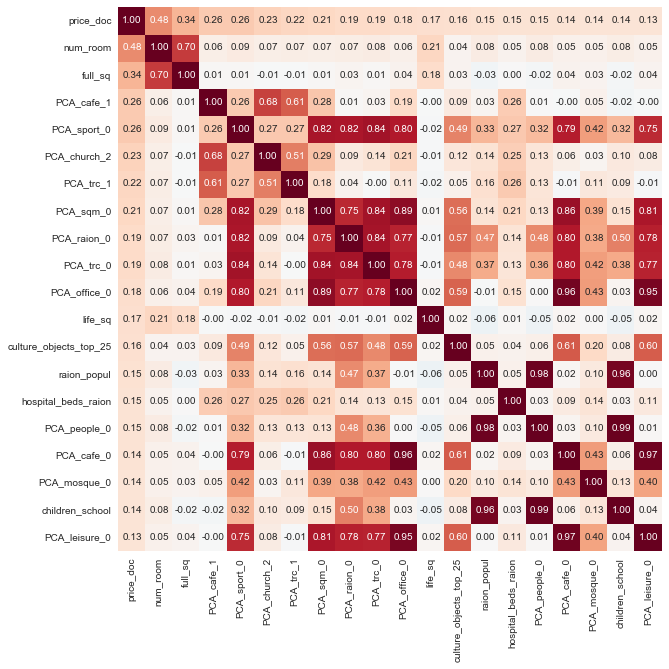

In [29]:
## Top 20 correlated variables
corrmat = alldata[wpca].corr()
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price_doc')['price_doc'].index
cm = alldata[cols].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [30]:
alldata[wpca].head()

,PCA_build_0,PCA_build_1,PCA_build_2,PCA_build_3,PCA_build_4,PCA_build_5,PCA_build_6,PCA_cafe_0,PCA_cafe_1,PCA_cafe_2,...,mnth_yr,num_room,preschool_quota,price_doc,product_type,railroad_1line,raion_popul,school_quota,state,water_1line
0,-1.326201,-1.818847,-0.944107,-1.067107,-1.454226,0.032794,0.302320,-1.062703,-0.333871,-0.156298,...,5,NaN,5001.0,5850000.0,0,0,155572,11065.0,NaN,0
1,-1.045097,-0.292023,0.586967,0.091654,0.018521,-0.459926,0.229294,-1.000068,-0.454333,-0.070946,...,5,NaN,3119.0,6000000.0,0,0,115352,6237.0,NaN,0
2,-0.606151,0.693676,0.999735,0.068354,0.048365,-0.584688,-0.485233,-1.306913,-0.276736,-0.194894,...,5,NaN,1463.0,5700000.0,0,0,101708,5580.0,NaN,0
3,1.712150,-1.216787,-1.244073,-1.214790,0.331086,1.400514,-1.162727,-1.496184,-0.498930,0.011681,...,53,NaN,6839.0,13100000.0,0,0,178473,17063.0,NaN,0
4,2.648957,5.599060,1.044620,-2.787453,-2.302500,1.394250,0.991861,18.735346,4.101895,-3.577521,...,53,NaN,3240.0,16331452.0,0,1,108171,7770.0,NaN,0


In [31]:
train_col = [c for c in alldata[wpca].columns if c not in ['Source']]
train_final = alldata[alldata.Source=='Train'][train_col]
X_train = train_final.drop('price_doc',axis=1)
Y_train = train_final.price_doc
X_test = alldata[alldata.Source=='Test'][train_col].drop('price_doc',axis=1)

In [32]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}
dtrain = xgb.DMatrix(X_train, Y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_test)


In [33]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.1969e+06	test-rmse:8.20985e+06
[50]	train-rmse:2.01508e+06	test-rmse:2.83837e+06
[100]	train-rmse:1.57465e+06	test-rmse:2.68393e+06
[150]	train-rmse:1.40035e+06	test-rmse:2.66041e+06
[200]	train-rmse:1.26487e+06	test-rmse:2.6536e+06
[250]	train-rmse:1.15396e+06	test-rmse:2.65116e+06


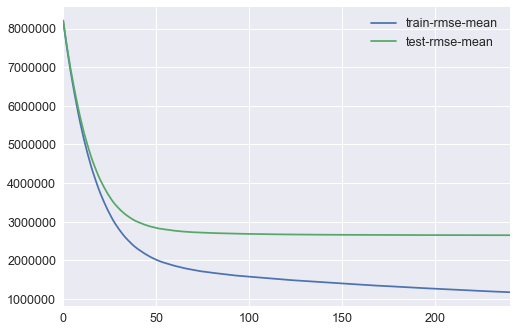

In [34]:
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.show()

In [35]:
num_boost_rounds = len(cv_output)
num_boost_rounds

241

In [36]:
def modelfit(alg, X_train, Y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, Y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='rmse',verbose_eval=50, show_stdv=False, early_stopping_rounds=early_stopping_rounds)
        #alg.set_params(n_estimators=cvresult.shape[0])
        global num_boost_rounds
        num_boost_rounds = len(cvresult)
        print(num_boost_rounds)
        cvresult[['train-rmse-mean', 'test-rmse-mean']].plot()
        plt.show()

[0]	train-rmse:8.50275e+06	test-rmse:8.50352e+06
[50]	train-rmse:5.63315e+06	test-rmse:5.72782e+06
[100]	train-rmse:3.97843e+06	test-rmse:4.19215e+06
[150]	train-rmse:3.05806e+06	test-rmse:3.40044e+06
[200]	train-rmse:2.5625e+06	test-rmse:3.02198e+06
[250]	train-rmse:2.29245e+06	test-rmse:2.84181e+06
[300]	train-rmse:2.13731e+06	test-rmse:2.75485e+06
[350]	train-rmse:2.03967e+06	test-rmse:2.70861e+06
[400]	train-rmse:1.97385e+06	test-rmse:2.68103e+06
[450]	train-rmse:1.92159e+06	test-rmse:2.66292e+06
[500]	train-rmse:1.87806e+06	test-rmse:2.64863e+06
[550]	train-rmse:1.83994e+06	test-rmse:2.63802e+06
[600]	train-rmse:1.80749e+06	test-rmse:2.63023e+06
[650]	train-rmse:1.7783e+06	test-rmse:2.62261e+06
[700]	train-rmse:1.75054e+06	test-rmse:2.61658e+06
[750]	train-rmse:1.72371e+06	test-rmse:2.6121e+06
[800]	train-rmse:1.69907e+06	test-rmse:2.6086e+06
[850]	train-rmse:1.67533e+06	test-rmse:2.60528e+06
[900]	train-rmse:1.65227e+06	test-rmse:2.60263e+06
[950]	train-rmse:1.63078e+06	test-rmse

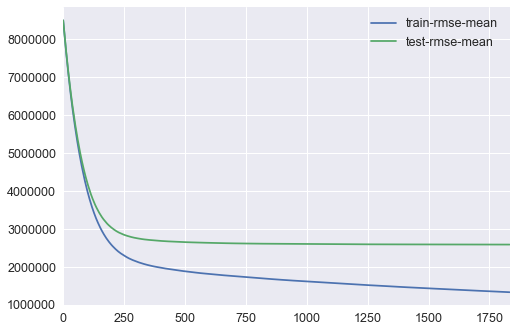

In [38]:
from xgboost.sklearn import XGBRegressor
xgb2 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=7,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.6,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=100,
 reg_lambda=1,
 seed=27)
modelfit(xgb2, X_train, Y_train)

In [40]:
num_boost_rounds

1834

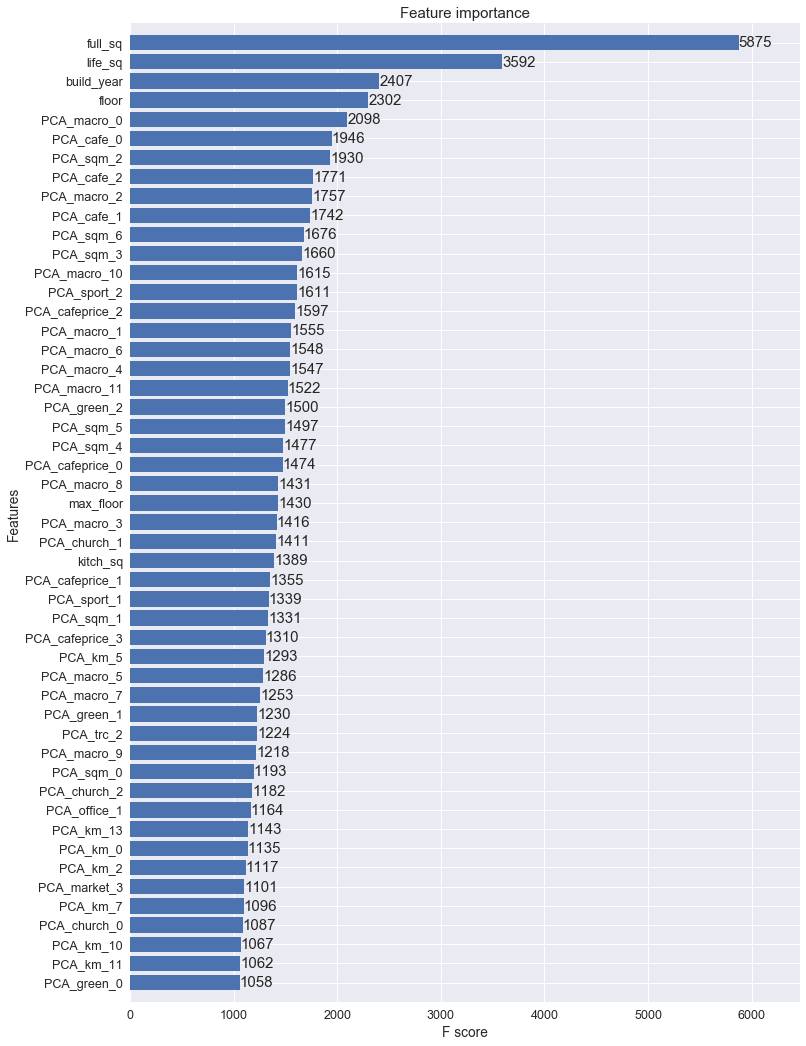

In [41]:
#model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)
model = xgb.train(xgb2.get_xgb_params(), dtrain, num_boost_round= num_boost_rounds)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [42]:
preds = model.predict(dtest)

In [43]:
output = pd.DataFrame({'id': id_test, 'price_doc': preds})
output.head()

,id,price_doc
0,30474,5600661.0
1,30475,8617224.0
2,30476,5638857.5
3,30477,6664119.0
4,30478,5423949.0


In [44]:
output.to_csv('xgb_v14_PCA_rate0.01_deletetime.csv', index=False)

In [ ]:
#75 31964
#100 31912 
#120 31897 *
#217 ?????